# Snow Detection Using Spark

## Introduction

In this Jupyter notebook, we will build an SVM classifier for Snow/Ice detection using Spark for the Proba-V 100m Top Of Atmosphere (TOA) Radiometry data.

## Data

### Radiometry Data

The Radiometry file is contained in a GeoTIFF file format. The file contains 4 raster bands:
1. RED
1. NIR
1. BLUE
1. SWIR

Each raster band is a pixel grid $Y*X$ where each value of the grid represents the TOA Reflectance value for that band for that pixel.

### Status Map
There is also a status map file containing a single band. For each pixel in that band, the value represents the class of that pixel.

In our case, the flag we are interested in is coded in binary as $100$, representing that the corresponding pixel in the Radiometry file is Snow or Ice, as documented in the Proba-V User Manual.

## Reading the files


### Imports

We will be using the following libraries / frameworks:
1. *numpy*: for numerical processing
1. *gdal*: for reading GeoTIFF files
1. *seaborn*: for plotting
1. *pandas*: for handling small DataFrames
1. *spark*

In [1]:
import numpy as np
import requests
import gdal

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import pyspark

### Setting up the Spark Context

In order to be able to access our Spark cluster, we first need to set up our Spark Context.
The below snippet shows how to do this and also shows how to modify the default configuration.

In [2]:
from pyspark.conf import SparkConf
conf = SparkConf()
conf.set('spark.yarn.executor.memoryOverhead', 1024)
conf.set('spark.executor.memory', '8g')
conf.set('spark.executor.cores', '2')
conf.set('spark.executor.instances',10)
sc = pyspark.SparkContext(conf=conf)
sqlContext = pyspark.SQLContext(sc)

The files are stored in a shared folder as defined below. 
The complete list of files can be requested using an API, but in our case we will be focusing on an area of the Alps, where there is plenty of Snow/Ice areas.

The Radiometry files end with *_RADIOMETRY.tif* whereas the status map ends with *_SM.tif*.

In [3]:
files = [
    "/data/MTDA/TIFFDERIVED/PROBAV_L3_S5_TOA_100M/2015/20151121/PROBAV_S5_TOA_20151121_100M_V101/PROBAV_S5_TOA_X18Y02_20151121_100M_V101.tif"
]

bands = [
    "RED",
    "NIR",
    "BLUE",
    "SWIR"
]

def radiometry_file(filename):
    return filename[:-4] + "_RADIOMETRY.tif"

def status_file(filename):
    return filename[:-4] + "_SM.tif"

### Processing the files

In order to read the files in a parallel manner, we need to instruct Spark to parallelize our list of files.

In [4]:
data_files = sc.parallelize([(status_file(f), radiometry_file(f)) for f in files]).cache()
data_files

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:396

Because our files are so large, we don't want to read the complete file in a single run. Instead, we will split each file into chunks, read each chunk and then combine the chunks.

This will also enable us to distribute the reading of our files to different Spark Executors, so that each Spark Executor reads a specific part of each file.

In [5]:
def makeSplits( files, splits=100 ):
    statusmap, radiometry = files
    dataset = gdal.Open(statusmap)
    status = dataset.GetRasterBand(1)
    del dataset
    XSize = status.XSize
    YSize = status.YSize
    
    chunks = []
    chunksize = (int(XSize / float(splits)), int(YSize / float(splits)))
    for x in range(0, XSize, chunksize[0]):
        for y in range(0, YSize, chunksize[1]):
            chunks.append({
                    'statusmap': statusmap,
                    'radiometry': radiometry,
                    'x': (x, min(XSize - x, chunksize[0])),
                    'y': (y, min(YSize - y, chunksize[1]))
                })
    
    return chunks

chunks = data_files.flatMap(makeSplits).repartition(100)
chunks.take(1)

[{'radiometry': '/data/MTDA/TIFFDERIVED/PROBAV_L3_S5_TOA_100M/2015/20151121/PROBAV_S5_TOA_20151121_100M_V101/PROBAV_S5_TOA_X18Y02_20151121_100M_V101_RADIOMETRY.tif',
  'statusmap': '/data/MTDA/TIFFDERIVED/PROBAV_L3_S5_TOA_100M/2015/20151121/PROBAV_S5_TOA_20151121_100M_V101/PROBAV_S5_TOA_X18Y02_20151121_100M_V101_SM.tif',
  'x': (0, 100),
  'y': (0, 100)}]

In [6]:
chunks.count()

10201

We can now define the functions to read each chunk.

In this process, what we want to accomplish is to end up with a list such that each element is a single pixel from the GeoTIFF files containing both the corresponding bitmask from the statusmap and the Reflectance for each individual band.

In [7]:
def parseTargets(statusmap, x, y):
    dataset = gdal.Open(statusmap)
    status = dataset.GetRasterBand(1)
    ret = status.ReadAsArray(x[0], y[0], x[1], y[1])
    del dataset
    return np.array(ret).flatten(order='F').tolist()
    
def parseFeatures( radiometry, x, y ):
    raster = gdal.Open(radiometry)
    raster_bands = [ raster.GetRasterBand(i).ReadAsArray(x[0], y[0], x[1], y[1]) for i in xrange(1, raster.RasterCount + 1) ]
    # 4 * Y * X
    
    del raster
    raster_bands = np.transpose(raster_bands)
    # Y * 4 * X

    raster_bands = raster_bands.reshape((len(raster_bands) * len(raster_bands[0]), len(raster_bands[0][0])))
    
    # Y * X * 4
    return raster_bands.tolist()

def parseChunk(chunk):
    return zip(
        parseTargets(chunk['statusmap'], chunk['x'], chunk['y']), 
        parseFeatures(chunk['radiometry'], chunk['x'], chunk['y'])
    )

dataset = chunks.flatMap(parseChunk)
dataset.take(5)

[(243, [763, 802, 873, 306]),
 (243, [765, 803, 875, 308]),
 (243, [767, 807, 878, 308]),
 (243, [773, 807, 880, 307]),
 (243, [772, 812, 878, 306])]

Some pixels contain invalid data. In such cases, one of the Reflectance value will be equal to $-1$.
Since those pixels contain incomplete data, we might as well filter them out.

In [8]:
def is_valid(row):
    for v in row[1]:
        if v == -1:
            return False
    return True

dataset = dataset.filter(is_valid).repartition(100)
dataset.take(5)

[(123, [1420, 1493, 2113, 645]),
 (123, [1314, 1376, 1549, 622]),
 (123, [1257, 1301, 1311, 639]),
 (251, [1245, 1278, 1322, 694]),
 (123, [1297, 1324, 1949, 778])]

As mentioned earlier, the mask for Snow/Ice is $100$. Since we are only interested in those, we can define a function to convert the complete bitmask into a single bit equal to 1 if the pixel is Snow/Ice and 0 otherwise.

In [9]:
def is_snow(row):
    return (int(row[0] & 0b100 != 0) , row[1])

dataset = dataset.map(is_snow).cache()
dataset.take(5)

[(0, [1178, 1197, 1297, 511]),
 (0, [1160, 1204, 1242, 484]),
 (0, [1094, 1144, 1213, 476]),
 (0, [1069, 1103, 1215, 485]),
 (0, [1055, 1068, 1213, 498])]

Since this is a dataset we will be using very often, we might as well cache it. The following snippet instructs Spark exactly of this.

In [10]:
dataset = dataset.cache()

### Visualizing the data

Now we are ready to do some visualizations. Before we go further, let's take a balanced sample from our dataset, meaning about the same number of positive (snow/ice) and negative samples. 

In [11]:
from pyspark.mllib.regression import LabeledPoint

def parseSample(row):
    return LabeledPoint( row[0], row[1])

def sample(size):
    sizes = dataset.countByKey()
    sample_fractions = {
        0.0: float(size / 2) / sizes[0.0],
        1.0: float(size / 2) / sizes[1.0] 
    }
    
    samples = dataset.sampleByKey( 
        withReplacement = False, 
        fractions = sample_fractions
    ).map(parseSample).cache()
    
    return samples

samples = sample(500)
positives = samples.filter(lambda r: r.label == 1).map(lambda r: np.append(r.features, r.label)).collect()
negatives = samples.filter(lambda r: r.label == 0).map(lambda r: np.append(r.features, r.label)).collect()
all_data = positives + negatives
df = pd.DataFrame(all_data, columns=bands + ["snow"])
df

,RED,NIR,BLUE,SWIR,snow
0,738.0,713.0,954.0,166.0,1.0
1,1812.0,2062.0,1387.0,261.0,1.0
2,1954.0,1962.0,1296.0,318.0,1.0
3,1757.0,2109.0,1389.0,353.0,1.0
4,1196.0,1233.0,1815.0,302.0,1.0
5,668.0,667.0,986.0,175.0,1.0
6,1417.0,1383.0,1470.0,304.0,1.0
7,676.0,657.0,953.0,103.0,1.0
8,777.0,940.0,943.0,201.0,1.0
9,987.0,1003.0,1188.0,348.0,1.0


We can now visualize our sample.

The following box plots shows us that there are indeed notable differences in the distributions for snow and not snow, confirming that building a classifier should be possible.

/opt/rh/python27/root/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


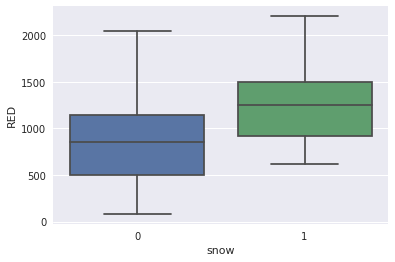

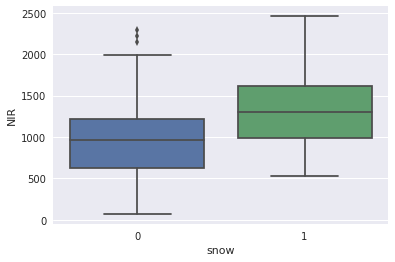

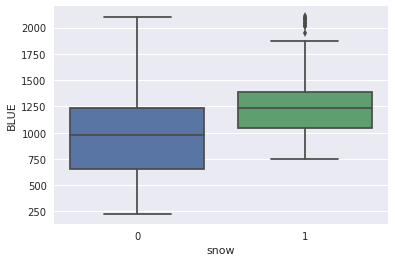

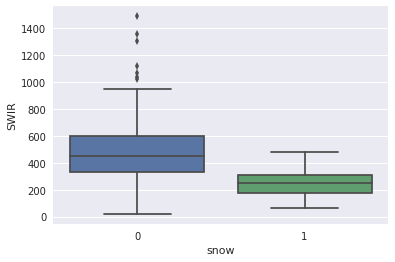

In [12]:
for band in bands:
    sns.boxplot(x='snow', y=band, order=[0, 1], data=df)
    plt.show()

Another way to look at the data is using scatter plots, to see if there is any correlations between the different bands but also to see if there is any interaction between the bands for the snow class.

The following pair plots show that:
1. There is a high correlation between RED, NIR and BLUE.
1. There is clearly a cutoff point when RED > 500 and SWIR < 500

This confirms the following:
1. The classes are linearly separable but
1. Separation requires interaction features

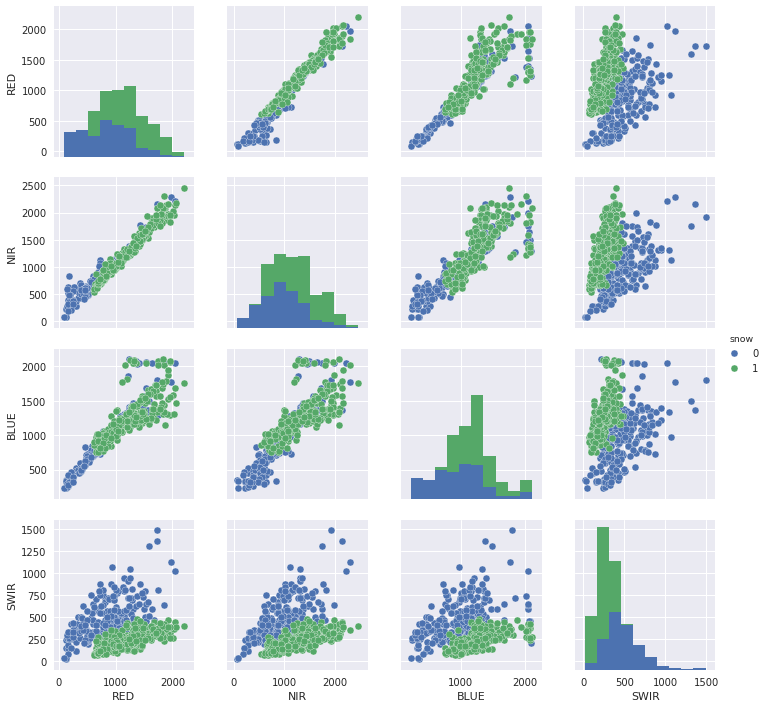

In [13]:
sns.pairplot(df, hue='snow', vars=bands, hue_order=[0, 1])

### Building the classifier

First, we need to do some preprocessing before we can build our classifier.

1. SVM works better when the data is rescaled
1. We need to introduce interaction variables, e.g. by building a polynomial expansion
1. SVM generally requires the dataset to be balanced (or use class weights). Since we have so many available positive samples, we will simply balance our dataset by undersampling our negative class.

So let's do just that, as follows:

In [14]:
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.ml import Pipeline

def transform(data):
    polyExpansion = PolynomialExpansion(
        inputCol="features",
        outputCol="polyFeatures",
        degree=2
    )

    scaler = StandardScaler(
        withMean=True,
        withStd=True,
        inputCol="polyFeatures",
        outputCol="scaledFeatures"
    )

    pipeline = Pipeline(stages=[polyExpansion, scaler])

    X = data.toDF()
    transformer = pipeline.fit(X)
    X = transformer.transform(X).map(lambda x: x.scaledFeatures)
    y = data.map(lambda p: p.label)
    return (transformer, y.zip(X).map(parseSample))

transformer, dataset = transform(sample(10000))
dataset = dataset.cache()
dataset.take(1)

[LabeledPoint(0.0, [0.0839797425461,-0.120977571692,0.0518000569338,-0.126372826923,-0.139212193821,0.188362545177,-0.036065033032,-0.0419035185357,0.0152015713184,0.0357256305209,0.0135277392015,-0.0183843637466,0.0632267441657,-0.17243522452])]

We will train our classifier using 75% of the dataset and test it on the remaining 25%.
So let's split it first:

In [15]:
train_data, test_data = dataset.randomSplit([0.75, 0.25])
train_data = train_data.cache()
test_data = test_data.cache()

Finally, we can train and test our model.

In [16]:
from sklearn.metrics import precision_recall_fscore_support

def train(training_data, iterations, regParam, step):
    model = SVMWithSGD.train(training_data, iterations=iterations, regParam=regParam, step=step)
    return model

def evaluate(model, train_data, test_data):
    train_y = train_data.map(lambda p: p.label).collect()
    test_y = test_data.map(lambda p: p.label).collect()
    train_predictions = train_data.map(lambda p: model.predict(p.features)).collect()
    test_predictions = test_data.map(lambda p: model.predict(p.features)).collect()
    
    _, _, train_f, _ = precision_recall_fscore_support(train_y, train_predictions, average='binary')
    _, _, test_f, _ = precision_recall_fscore_support(test_y, test_predictions, average='binary')
    
    return (train_f, test_f)

def train_evaluate(train_data, test_data, iterations, regParam, step):    
    print "Training with", train_data.count(), "samples"
    print "Params: ", iterations, regParam, step
    model = train(train_data, iterations, regParam, step)
    train_f, test_f = evaluate(model, train_data, test_data)
    
    print "Train F1", train_f
    print "Test F1", test_f
    print ""
    return (model, (train_data.count(), iterations, regParam, step, train_f, test_f))

model, results = train_evaluate(train_data,
                         test_data,
                         iterations=100, 
                         step=1.0, 
                         regParam=0.)

Training with 7609 samples
Params:  100 0.0 1.0
Train F1 0.923278688525
Test F1 0.911188004614



### Visualising the output

We can draw the GeoTIFF using *matplotlib*. But the files are so big that we also need to reduce its resolution.
We can re-use the chunking mechanism used previously and plot the average values for every chunk instead.

However, we will need to keep track of the position of the chunk, so we add that to our function.

In [17]:
def makeSplits( files, splits=100 ):
    statusmap, radiometry = files
    sm = gdal.Open(statusmap)
    status = sm.GetRasterBand(1)
    del sm
    XSize = status.XSize
    YSize = status.YSize
    
    chunks = []
    chunksize = (int(XSize / float(splits)), int(YSize / float(splits)))
    for x in range(0, splits):
        for y in range(0, splits):
            chunks.append({
                    'statusmap': statusmap,
                    'radiometry': radiometry,
                    'chunk': (x, y),
                    'x_range': (x * chunksize[0], chunksize[0]),
                    'y_range': (y * chunksize[1], chunksize[1])
                })
    
    return chunks

chunks = data_files.flatMap(makeSplits).repartition(100)
chunks.take(1)

[{'chunk': (0, 0),
  'radiometry': '/data/MTDA/TIFFDERIVED/PROBAV_L3_S5_TOA_100M/2015/20151121/PROBAV_S5_TOA_20151121_100M_V101/PROBAV_S5_TOA_X18Y02_20151121_100M_V101_RADIOMETRY.tif',
  'statusmap': '/data/MTDA/TIFFDERIVED/PROBAV_L3_S5_TOA_100M/2015/20151121/PROBAV_S5_TOA_20151121_100M_V101/PROBAV_S5_TOA_X18Y02_20151121_100M_V101_SM.tif',
  'x_range': (0, 100),
  'y_range': (0, 100)}]

Now that our chunks have a position, we need to propagate the position up to the pixel.
We then take the average for every chunk and then plot the average.

In [18]:
def is_snow_mask(mask):
    return (int(mask & 0b100 != 0))

def parseChunk(chunk):
    statusmap = map(is_snow_mask, parseTargets(chunk['statusmap'], chunk['x_range'], chunk['y_range']))
    features = parseFeatures(chunk['radiometry'], chunk['x_range'], chunk['y_range'])
    return (chunk['chunk'], map(parseSample, zip(statusmap, features)))

all_data = chunks.map(parseChunk)

def average_snow(data):
    return np.mean(map(lambda x: x.label, data))

averaged_by_chunk = all_data.map(lambda x: (x[0], average_snow(x[1]))).cache()
averaged_by_chunk.count()

10000

In [19]:
img_flat = averaged_by_chunk.collect()

Here is how our original data looked like.

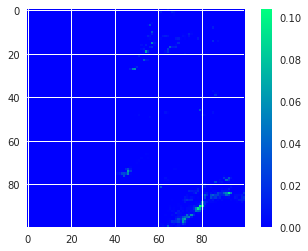

In [20]:
img = np.array(img_flat)[:, 1].reshape(100, 100, order='F').astype('float')
plt.imshow(img, cmap='winter')
plt.colorbar()

Now, instead of drawing the original Snow/Ice component of our pixels, we will instead use our classifier to predict that value and then draw that one instead.

In [21]:
all_df = all_data.flatMap(lambda x: [{'x': x[0][0], 'y': x[0][1], 'features': p.features, 'label': p.label} for p in x[1]]).toDF()

/usr/hdp/current/spark-client/python/pyspark/sql/context.py:209: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [22]:
groups = transformer.transform(all_df).map(lambda x: ((x.x, x.y), model.predict(x.scaledFeatures))).groupByKey().cache()

In [23]:
averaged_by_chunk = groups.map(lambda g: (g[0], np.mean(list(g[1])))).collect()

In [24]:
img = np.zeros((100, 100))
for x in np.array(averaged_by_chunk):
    pos, v = x
    img[pos[1]][pos[0]] = v

### Final result

Here's how our classifier estimated snow. It looks roughly the same as the original one, except it looks to be slightly more permissive for the snow class.

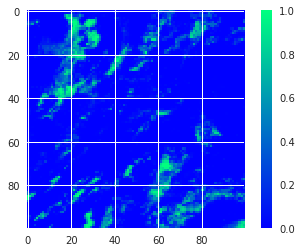

In [25]:
plt.imshow(img, cmap='winter')
plt.colorbar()